<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/MFCC_Ceylan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
data_dir = '/content/drive/MyDrive/'   

In [ ]:
transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

In [ ]:
train_data = datasets.ImageFolder(data_dir + 'train_set', transform=transforms)
test_data = datasets.ImageFolder(data_dir + 'val_set', transform=transforms)


In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 256, 3)

        self.conv2 = nn.Conv2d(256, 256, 3)
        
        self.conv3 = nn.Conv2d(256, 512, 3)
       
        self.conv4 = nn.Conv2d(512, 512, 4)

        self.pool = nn.AvgPool2d(3,2,1)

        self.final = nn.Conv2d(512, 1, (51,60))
        
        self.fc1 = nn.Linear(20, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print('conv1')
        #print(x.shape)

        x = F.relu(self.conv2(x))
        #print('conv2')
        #print(x.shape)

        x = self.pool(x)
        #print('pool1')
        #print(x.shape)

        x = F.relu(self.conv3(x))
        #print('conv3')
        #print(x.shape)

        x = self.pool(x)
        #print('pool2')
        #print(x.shape)

        x = F.relu(self.conv4(x))
        #print('conv4')
        #print(x.shape)

        
        x = self.final(x)
        #print('final')
        #print(x.shape)


        x = F.relu(self.fc1(x))
        #print('1x256')
        #print(x.shape)

        x = F.relu(self.fc2(x))
        #print('1x128')
        #print(x.shape)

        x = self.fc3(x)
        #print('1x10')
        #print(x.shape)

        x = x.reshape((1,10))
        #print('reshaped')
        #print(x.shape)

        return x


net = CNN()
print(net)

CNN(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (final): Conv2d(512, 1, kernel_size=(51, 60), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
for param in model.parameters():
    param.requires_grad = True
    
model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

CNN(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (final): Conv2d(512, 1, kernel_size=(51, 60), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'working_mod.pth')

Epoch 1/1.. Train loss: 52.470.. Test loss: 1439.765.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 2104.513.. Test loss: 65.446.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 35.206.. Test loss: 58.530.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 64.631.. Test loss: 19.841.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 21.719.. Test loss: 29.327.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 23.024.. Test loss: 40.632.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 27.324.. Test loss: 30.821.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 45.757.. Test loss: 94.639.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 93.651.. Test loss: 18.870.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 26.997.. Test loss: 70.051.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 76.894.. Test loss: 29.073.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 2.414.. Test loss: 14.757.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 0.367.. Test loss: 17.566.. Test accuracy: 0.100
Epoch 1/1.. Train loss: 19.909.. Tes

KeyboardInterrupt: ignored

In [ ]:
torch.save(model, 'working_mod.pth')

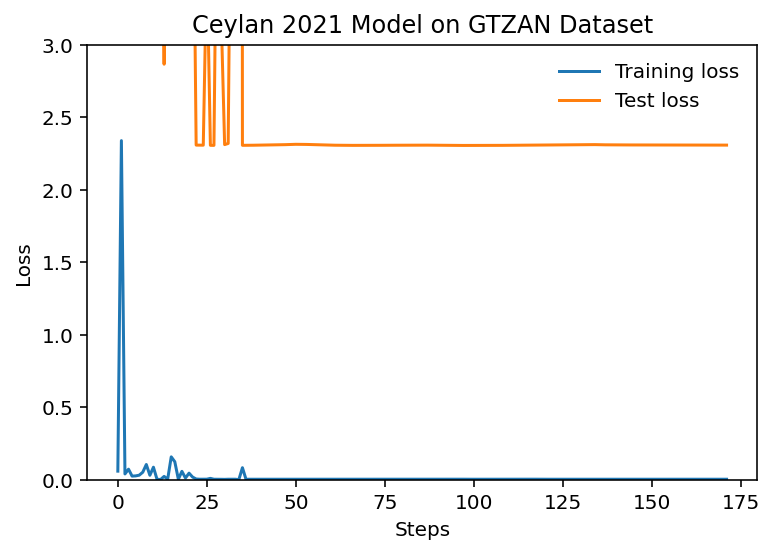

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.ylim(0,3)
plt.title("Ceylan 2021 Model on GTZAN Dataset")
plt.show()